In [1]:
import numpy as np
import pandas as pd

import os
import random
import glob
import gc
from tqdm import tqdm
import missingno as msno

import pyarrow as pa
import pyarrow.parquet as pq

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

In [2]:
sample_submission = pd.read_csv("../input/optiver-realized-volatility-prediction/sample_submission.csv")
sample_submission

,row_id,target
0,0-4,0.003048
1,0-32,0.003048
2,0-34,0.003048


In [3]:
test = pd.read_csv("../input/optiver-realized-volatility-prediction/test.csv")
test

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [4]:
book_test_parquet = pd.read_parquet("../input/optiver-realized-volatility-prediction/book_test.parquet/stock_id=0")
book_test_parquet

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,4,0,1.000049,1.000590,0.999656,1.000639,91,100,100,24
1,4,1,1.000049,1.000590,0.999656,1.000639,91,100,100,20
2,4,5,1.000049,1.000639,0.999656,1.000885,290,20,101,15


In [5]:
trade_test_parquet = pd.read_parquet("../input/optiver-realized-volatility-prediction/trade_test.parquet/stock_id=0")
trade_test_parquet

,time_id,seconds_in_bucket,price,size,order_count
0,4,7,1.000344,1,1
1,4,24,1.000049,100,7
2,4,27,1.000059,100,3


In [6]:
train = pd.read_csv("../input/optiver-realized-volatility-prediction/train.csv")
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [7]:
train.shape

(428932, 3)

In [8]:
train.dtypes

stock_id      int64
time_id       int64
target      float64
dtype: object

In [9]:
train.isnull().any(axis = 0)

stock_id    False
time_id     False
target      False
dtype: bool

In [10]:
len(set(train["stock_id"]))

112

In [11]:
train.groupby(["stock_id"]).size()

stock_id
0      3830
1      3830
2      3830
3      3830
4      3830
       ... 
122    3830
123    3830
124    3830
125    3830
126    3830
Length: 112, dtype: int64

In [12]:
len(set(train["time_id"]))

3830

In [13]:
stock = train.groupby("stock_id")["target"].agg(["mean", "median", "std", "count", "sum"]).reset_index()
stock

,stock_id,mean,median,std,count,sum
0,0,0.004028,0.003180,0.002855,3830,15.429071
1,1,0.004362,0.003719,0.002433,3830,16.704962
2,2,0.002385,0.001748,0.002339,3830,9.133223
3,3,0.006182,0.005422,0.003201,3830,23.675414
4,4,0.004197,0.003397,0.002879,3830,16.073408
...,...,...,...,...,...,...
107,122,0.003762,0.003176,0.002300,3830,14.407997
108,123,0.002506,0.001967,0.001816,3830,9.599594
109,124,0.003691,0.003143,0.001953,3830,14.135579
110,125,0.002016,0.001575,0.001703,3830,7.719409


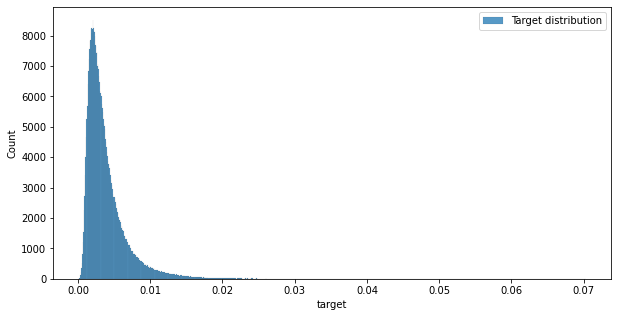

In [14]:
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.histplot(train["target"], label = "Target distribution")
plt.legend()
plt.show()

the mean of the mean of the target of each stock:  0.0038805243039130312


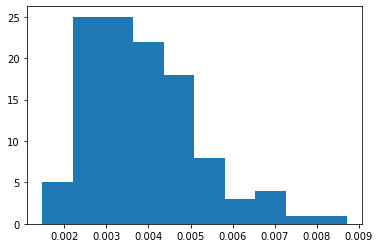

In [15]:
print("the mean of the mean of the target of each stock: ", stock["mean"].mean())
plt.hist(stock["mean"])
plt.show()

the mean of the sum of the target of each stock:  0.0038805243039130312


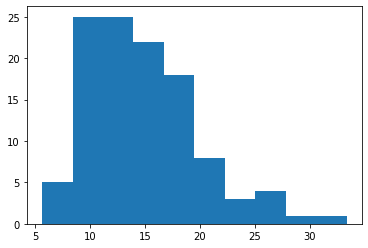

In [16]:
print("the mean of the sum of the target of each stock: ", stock["mean"].mean())
plt.hist(stock["sum"])
plt.show()

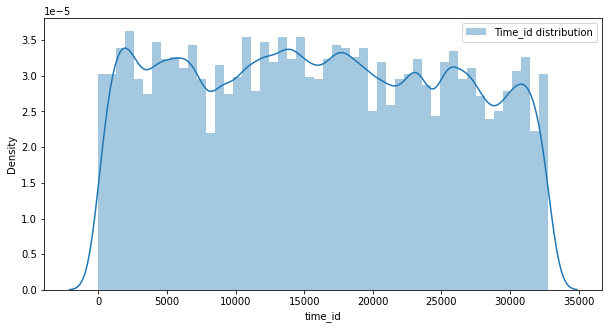

In [17]:
plt.figure(figsize = (10, 5))
sns.distplot(train["time_id"], label = "Time_id distribution")
plt.legend()
plt.show()

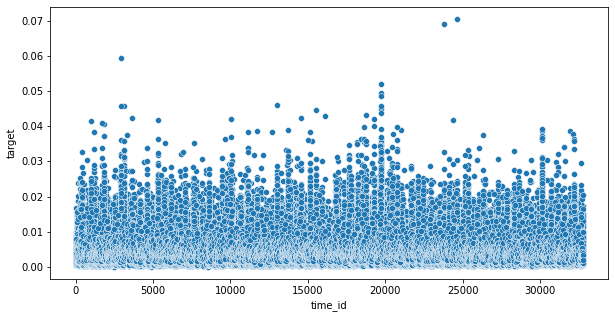

In [18]:
plt.figure(figsize = (10, 5))
sns.scatterplot(data = train, x = "time_id", y = "target")
plt.show()

In [19]:
stock_28 = train[train["stock_id"] == 28].reset_index().drop("index", 1)
min_index = stock_28["target"].idxmin()
min_time_id = stock_28.iloc[min_index]["time_id"]
print("For stock 28, the time_id of min target is", min_time_id, "and min target is", stock_28.iloc[min_index]["target"])

For stock 28, the time_id of min target is 20351.0 and min target is 0.000428459


In [20]:
max_index = stock_28["target"].idxmax()
max_time_id = stock_28.iloc[max_index]["time_id"]
print("For stock 28, the time_id of max target is", max_time_id, "and max target is", stock_28.iloc[max_index]["target"])

For stock 28, the time_id of max target is 3138.0 and max target is 0.035741236


In [21]:
book_28 = pd.read_parquet("../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=28")
trade_28 = pd.read_parquet("../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=28")

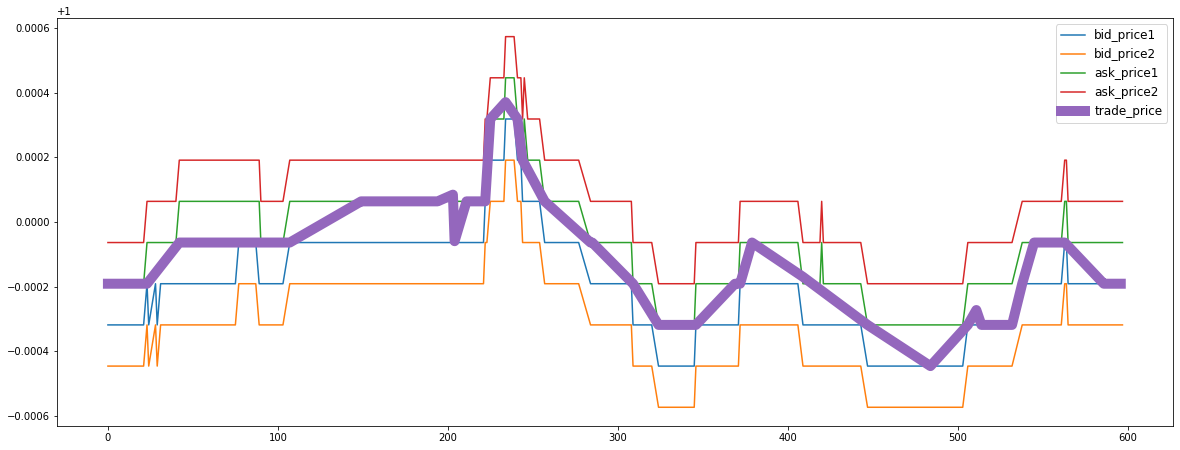

In [22]:
samples = ["bid_price1", "bid_price2", "ask_price1", "ask_price2"]
book_28_min = book_28[book_28["time_id"] == min_time_id]
trade_28_min = trade_28[trade_28["time_id"] == min_time_id]

plt.figure(figsize = (20, 7.5))

for i in samples:
    plt.plot(book_28_min["seconds_in_bucket"], book_28_min[i], label = i)

plt.plot(trade_28_min["seconds_in_bucket"], trade_28_min["price"], label = "trade_price", lw = 10)
plt.legend(fontsize = 12)
plt.show()

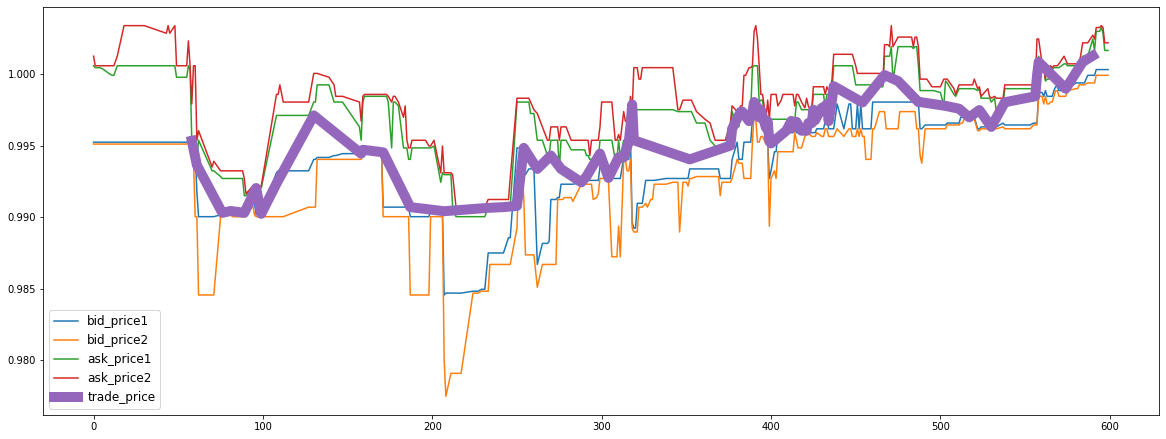

In [23]:
book_28_max = book_28[book_28["time_id"] == max_time_id]
trade_28_max = trade_28[trade_28["time_id"] == max_time_id]

plt.figure(figsize = (20, 7.5))

for i in samples:
    plt.plot(book_28_max["seconds_in_bucket"], book_28_max[i], label = i)

plt.plot(trade_28_max["seconds_in_bucket"], trade_28_max["price"], label = "trade_price", lw = 10)
plt.legend(fontsize = 12)
plt.show()

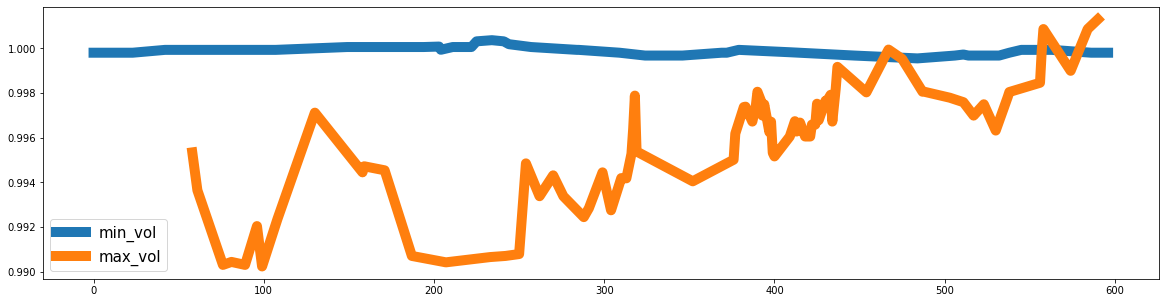

In [24]:
plt.figure(figsize = (20, 5))
plt.plot(trade_28_min["seconds_in_bucket"], trade_28_min["price"], lw = 10, label = "min_vol")
plt.plot(trade_28_max["seconds_in_bucket"], trade_28_max["price"], lw = 10, label = "max_vol")
plt.legend(fontsize = 15)
plt.show()

In [25]:
stock_id = "28"
book_28_11 = book_28[book_28["time_id"] == 11]
book_28_11.loc[:, 'stock_id'] = stock_id
trade_28_11 = trade_28[trade_28["time_id"] == 11]
trade_28_11.loc[:, 'stock_id'] = stock_id

In [26]:
book_28_11.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
438,11,0,0.999839,1.000402,0.999759,1.000563,1,4,300,304,28
439,11,1,0.999839,1.000402,0.999759,1.000563,101,4,300,304,28
440,11,5,0.999839,1.000402,0.999679,1.000563,101,4,100,404,28
441,11,12,0.999839,1.000402,0.999679,1.000563,101,4,200,504,28
442,11,14,0.999839,1.000402,0.999679,1.000563,101,20,100,504,28


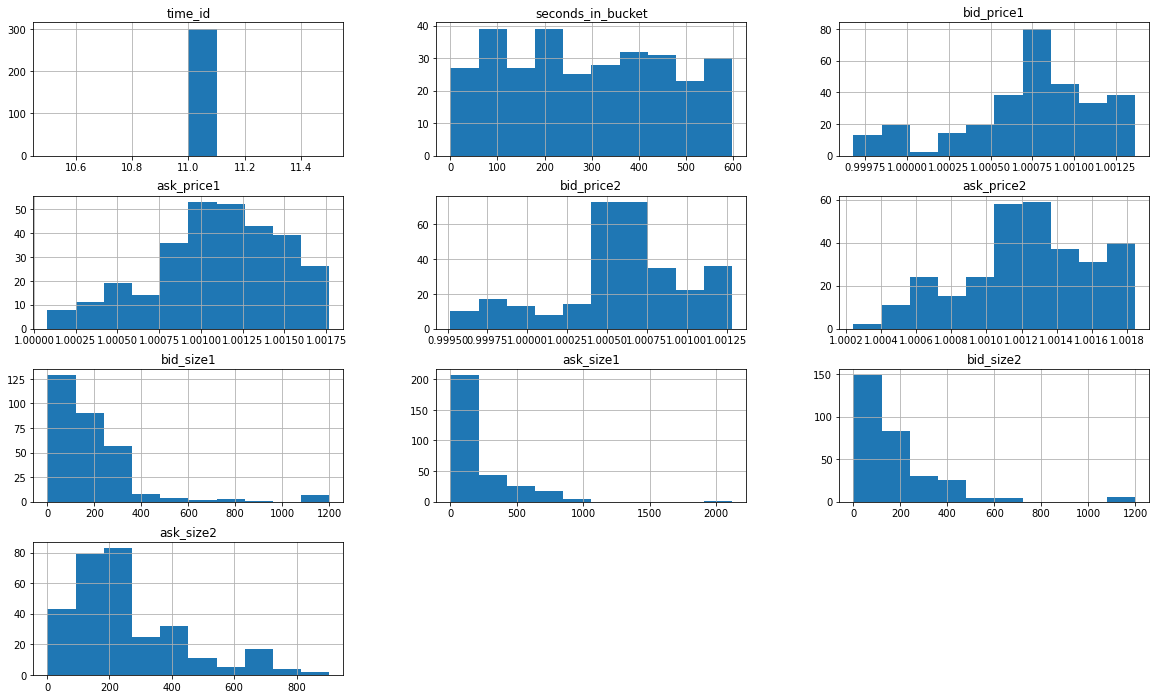

In [27]:
book_28_11.hist(figsize = (20, 12))
plt.show()

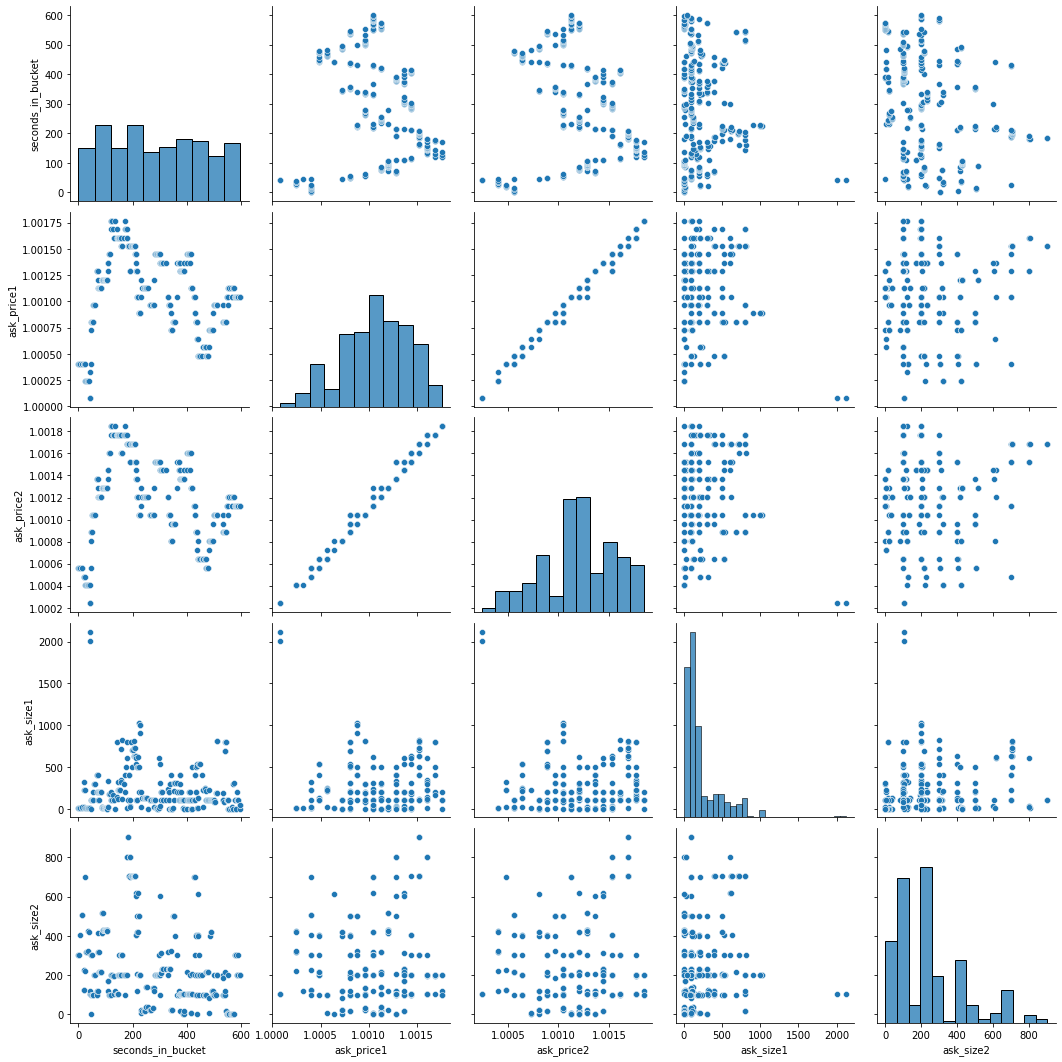

In [28]:
sns.pairplot(book_28_11[["seconds_in_bucket", "ask_price1", "ask_price2", "ask_size1", "ask_size2"]], diag_kind = "hist", height = 3)
plt.show()

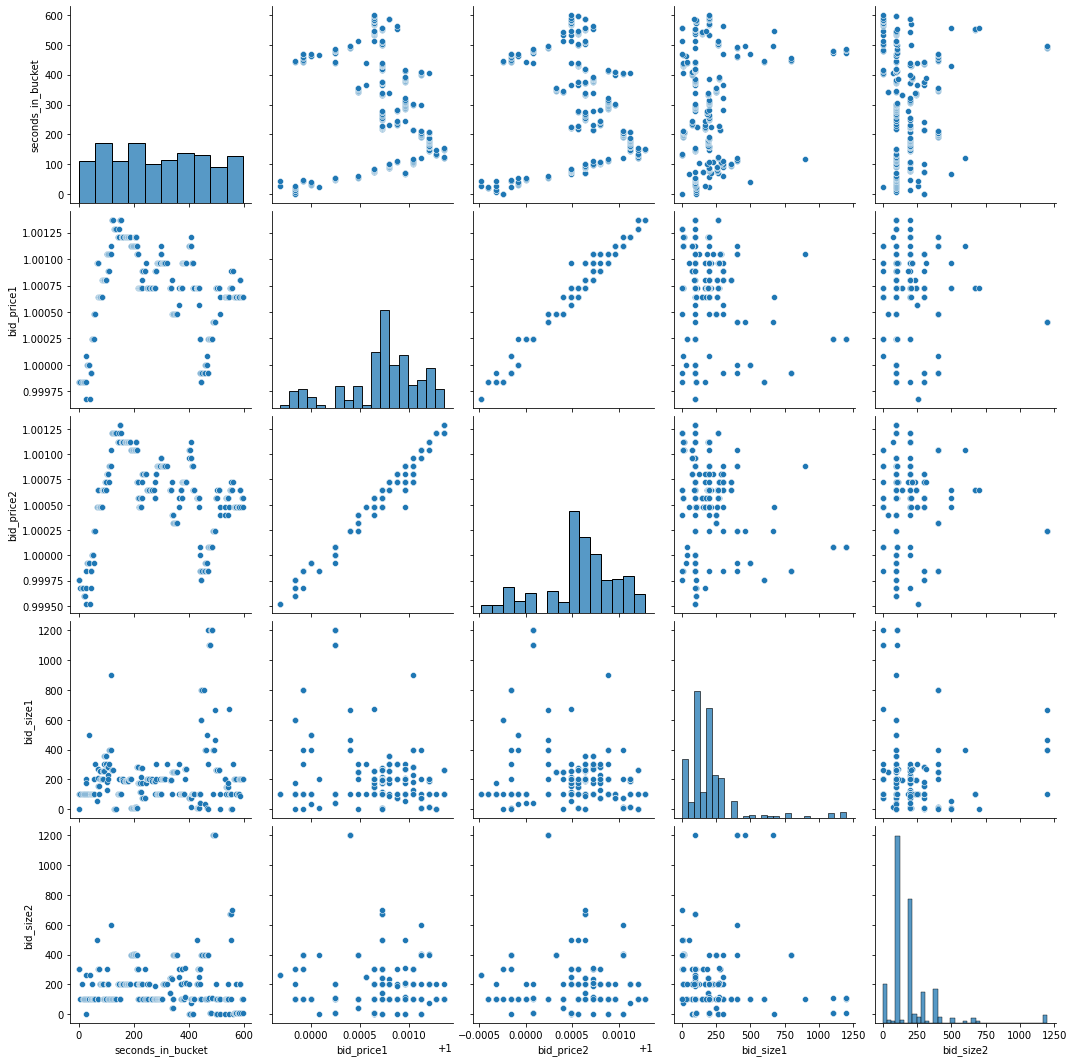

In [29]:
sns.pairplot(book_28_11[["seconds_in_bucket", "bid_price1", "bid_price2", "bid_size1", "bid_size2"]], diag_kind = "hist", height = 3)
plt.show()

In [30]:
trade_28_11.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
98,11,25,1.000321,200,2,28
99,11,26,1.000080,201,3,28
100,11,30,1.000000,73,1,28
101,11,42,1.000000,500,3,28
102,11,44,1.000080,2001,5,28


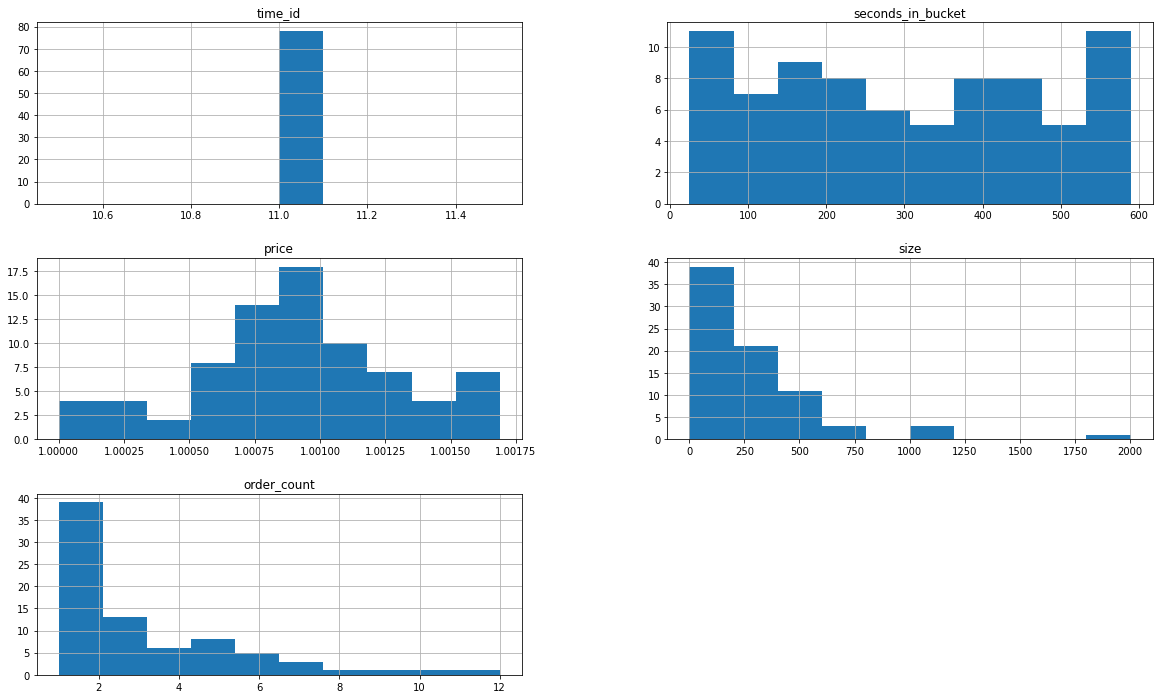

In [31]:
trade_28_11.hist(figsize = (20, 12))
plt.show()

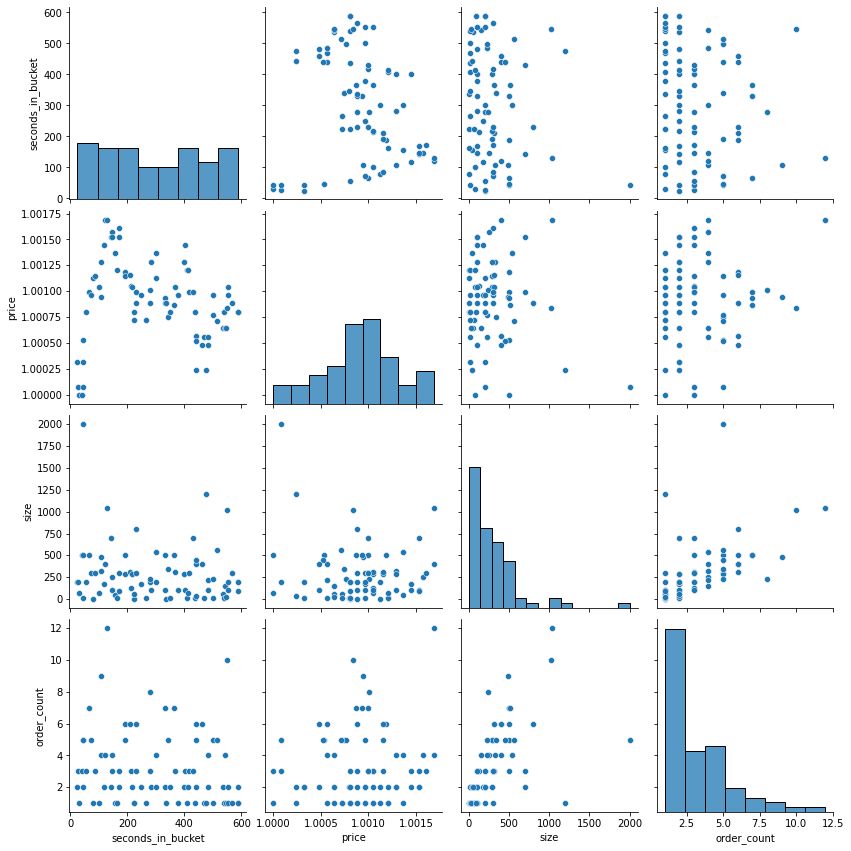

In [32]:
sns.pairplot(trade_28_11[["seconds_in_bucket", "price", "size", "order_count"]], diag_kind = "hist", height = 3)
plt.show()

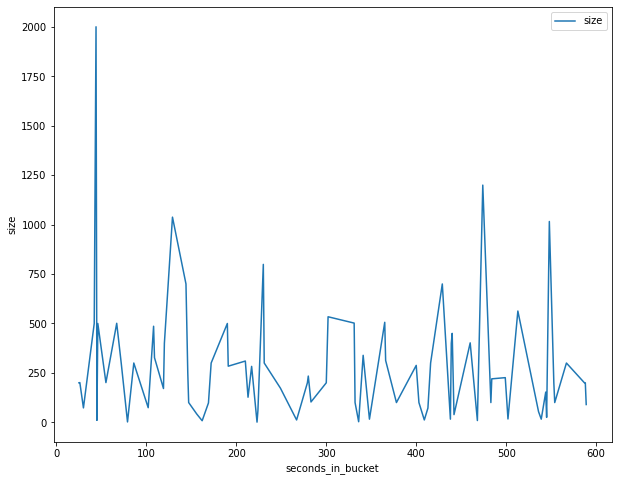

In [33]:
plt.figure(figsize = (10, 8))
sns.lineplot(x = trade_28_11["seconds_in_bucket"], y = trade_28_11["size"], data = trade_28_11)
plt.legend(labels = ["size"])
plt.show()

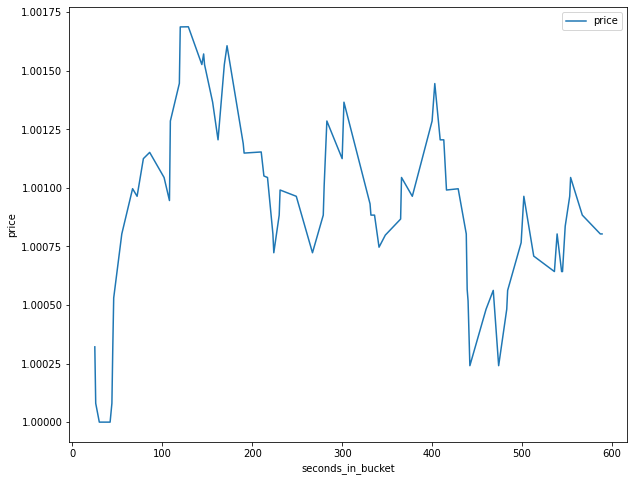

In [34]:
plt.figure(figsize = (10, 8))
sns.lineplot(x = trade_28_11["seconds_in_bucket"], y = trade_28_11["price"], data = trade_28_11)
plt.legend(labels = ["price"])
plt.show()

In [35]:
book_28_11['wap'] = (book_28_11['bid_price1'] * book_28_11['ask_size1'] +
                                book_28_11['ask_price1'] * book_28_11['bid_size1']) / (
                                       book_28_11['bid_size1']+ book_28_11['ask_size1'])

In [36]:
book_28_11.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,wap
438,11,0,0.999839,1.000402,0.999759,1.000563,1,4,300,304,28,0.999952
439,11,1,0.999839,1.000402,0.999759,1.000563,101,4,300,304,28,1.000380
440,11,5,0.999839,1.000402,0.999679,1.000563,101,4,100,404,28,1.000380
441,11,12,0.999839,1.000402,0.999679,1.000563,101,4,200,504,28,1.000380
442,11,14,0.999839,1.000402,0.999679,1.000563,101,20,100,504,28,1.000309


In [37]:
fig = px.line(book_28_11, x="seconds_in_bucket", y="wap", title='WAP of stock_id_28, time_id_11')
fig.show()

In [38]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

In [39]:
book_28_11.loc[:, "log_return"] = log_return(book_28_11["wap"])
book_28_11 = book_28_11[~book_28_11['log_return'].isnull()]

In [40]:
fig = px.line(book_28_11, x="seconds_in_bucket", y="log_return", title='Log return of stock_id_28, time_id_11')
fig.show()

In [41]:
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))
realized_vol = realized_volatility(book_28_11['log_return'])
print(f'Realized volatility for stock_id 28 on time_id 11 is {realized_vol}')

Realized volatility for stock_id 28 on time_id 11 is 0.0023012667652142185


In [42]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=book_28_11["seconds_in_bucket"], 
        y=book_28_11["bid_price1"], 
        mode='lines', 
        name='bid_price1'
    )
)
fig.add_trace(
    go.Scatter(
        x=book_28_11["seconds_in_bucket"], 
        y=book_28_11["bid_price2"], 
        mode='lines', 
        name='bid_price2'
    )
)

fig.add_trace(
    go.Scatter(
        x=trade_28_11["seconds_in_bucket"], 
        y=trade_28_11["price"], 
        mode='lines', 
        name='trade_price'
    )
)

fig.show()

In [43]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=book_28_11["seconds_in_bucket"], 
        y=book_28_11["ask_price1"], 
        mode='lines', 
        name='ask_price1'
    )
)
fig.add_trace(
    go.Scatter(
        x=book_28_11["seconds_in_bucket"], 
        y=book_28_11["ask_price2"], 
        mode='lines', 
        name='ask_price2'
    )
)

fig.add_trace(
    go.Scatter(
        x=trade_28_11["seconds_in_bucket"], 
        y=trade_28_11["price"], 
        mode='lines', 
        name='trade_price'
    )
)

fig.show()

In [44]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=book_28_11["seconds_in_bucket"], 
        y=book_28_11["bid_price1"], 
        mode='lines', 
        name='bid_price1'
    )
)
fig.add_trace(
    go.Scatter(
        x=book_28_11["seconds_in_bucket"], 
        y=book_28_11["bid_price2"], 
        mode='lines', 
        name='bid_price2'
    )
)

fig.add_trace(
    go.Scatter(
        x=book_28_11["seconds_in_bucket"], 
        y=book_28_11["ask_price1"], 
        mode='lines', 
        name='ask_price1'
    )
)
fig.add_trace(
    go.Scatter(
        x=book_28_11["seconds_in_bucket"], 
        y=book_28_11["ask_price2"], 
        mode='lines', 
        name='ask_price2'
    )
)

fig.add_trace(
    go.Scatter(
        x=trade_28_11["seconds_in_bucket"], 
        y=trade_28_11["price"], 
        mode='lines', 
        name='trade_price'
    )
)

fig.show()

In [45]:
book_28_11.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,wap,log_return
439,11,1,0.999839,1.000402,0.999759,1.000563,101,4,300,304,28,1.000380,0.000429
440,11,5,0.999839,1.000402,0.999679,1.000563,101,4,100,404,28,1.000380,0.000000
441,11,12,0.999839,1.000402,0.999679,1.000563,101,4,200,504,28,1.000380,0.000000
442,11,14,0.999839,1.000402,0.999679,1.000563,101,20,100,504,28,1.000309,-0.000072
443,11,19,0.999839,1.000402,0.999598,1.000482,101,20,100,125,28,1.000309,0.000000


In [46]:
temp_aggs = book_28_11.groupby(['time_id']).agg(
                                            bid_price1_min = ('bid_price1', 'min'),
                                            bid_price2_max = ('bid_price2', 'max'),
                                            bid_price1_mean = ('bid_price1', 'mean'),
                                            bid_price2_mean = ('bid_price2', 'mean'),
                                            bid_price1_median = ('bid_price1', 'median'),
                                            bid_price2_median = ('bid_price2', 'median'),
                                            ask_price1_min = ('ask_price1', 'min'),
                                            ask_price2_max = ('ask_price2', 'max'),
                                            ask_price1_mean = ('ask_price1', 'mean'),
                                            ask_price2_mean = ('ask_price2', 'mean'),
                                            ask_price1_median = ('ask_price1', 'median'),
                                            ask_price2_median = ('ask_price2', 'median'),
)

In [47]:
aggs_book_28_11 = pd.merge(book_28_11, temp_aggs, on=['time_id'], how='left')
aggs_book_28_11

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,...,bid_price1_mean,bid_price2_mean,bid_price1_median,bid_price2_median,ask_price1_min,ask_price2_max,ask_price1_mean,ask_price2_mean,ask_price1_median,ask_price2_median
0,11,1,0.999839,1.000402,0.999759,1.000563,101,4,300,304,...,1.000728,1.000591,1.000723,1.000643,1.00008,1.001848,1.001087,1.001195,1.001125,1.001205
1,11,5,0.999839,1.000402,0.999679,1.000563,101,4,100,404,...,1.000728,1.000591,1.000723,1.000643,1.00008,1.001848,1.001087,1.001195,1.001125,1.001205
2,11,12,0.999839,1.000402,0.999679,1.000563,101,4,200,504,...,1.000728,1.000591,1.000723,1.000643,1.00008,1.001848,1.001087,1.001195,1.001125,1.001205
3,11,14,0.999839,1.000402,0.999679,1.000563,101,20,100,504,...,1.000728,1.000591,1.000723,1.000643,1.00008,1.001848,1.001087,1.001195,1.001125,1.001205
4,11,19,0.999839,1.000402,0.999598,1.000482,101,20,100,125,...,1.000728,1.000591,1.000723,1.000643,1.00008,1.001848,1.001087,1.001195,1.001125,1.001205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,11,588,1.000804,1.001045,1.000643,1.001125,90,101,201,201,...,1.000728,1.000591,1.000723,1.000643,1.00008,1.001848,1.001087,1.001195,1.001125,1.001205
296,11,589,1.000643,1.001045,1.000482,1.001125,201,101,5,301,...,1.000728,1.000591,1.000723,1.000643,1.00008,1.001848,1.001087,1.001195,1.001125,1.001205
297,11,596,1.000643,1.001045,1.000563,1.001125,201,1,100,201,...,1.000728,1.000591,1.000723,1.000643,1.00008,1.001848,1.001087,1.001195,1.001125,1.001205
298,11,597,1.000643,1.001045,1.000563,1.001125,201,42,100,201,...,1.000728,1.000591,1.000723,1.000643,1.00008,1.001848,1.001087,1.001195,1.001125,1.001205


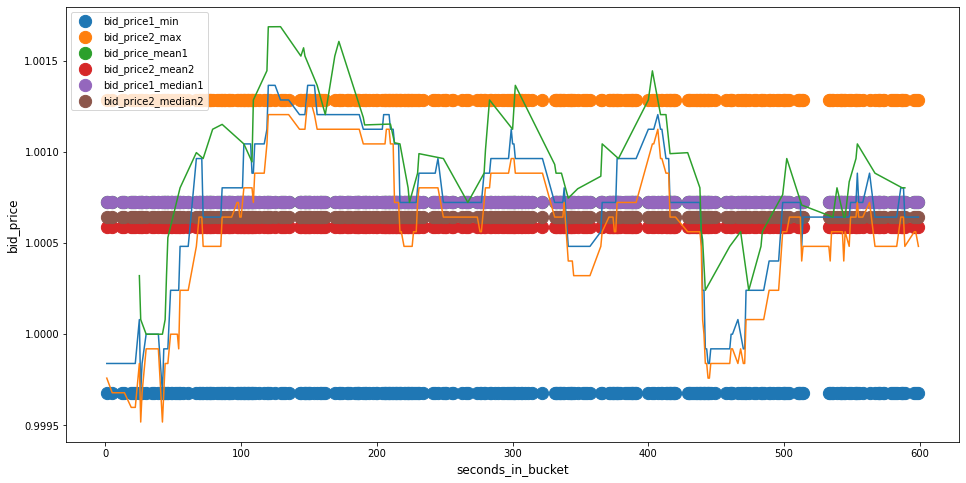

In [48]:
plt.figure(figsize=(16, 8))

plt.plot(book_28_11['seconds_in_bucket'], book_28_11['bid_price1'])
plt.plot(book_28_11['seconds_in_bucket'], book_28_11['bid_price2'])

plt.plot(trade_28_11['seconds_in_bucket'], trade_28_11['price'])

plt.scatter(x=aggs_book_28_11['seconds_in_bucket'], 
            y=aggs_book_28_11['bid_price1_min'],
            s=150,
            label='bid_price1_min'
           )
plt.scatter(x=aggs_book_28_11['seconds_in_bucket'], 
            y=aggs_book_28_11['bid_price2_max'],
            s=150,
            label='bid_price2_max'
           )
plt.scatter(x=aggs_book_28_11['seconds_in_bucket'], 
            y=aggs_book_28_11['bid_price1_mean'],
            s=150,
            label='bid_price_mean1'
           )
plt.scatter(x=aggs_book_28_11['seconds_in_bucket'], 
            y=aggs_book_28_11['bid_price2_mean'],
            s=150,
            label='bid_price2_mean2'
           )
plt.scatter(x=aggs_book_28_11['seconds_in_bucket'], 
            y=aggs_book_28_11['bid_price1_median'],
            s=150,
            label='bid_price1_median1'
           )
plt.scatter(x=aggs_book_28_11['seconds_in_bucket'], 
            y=aggs_book_28_11['bid_price2_median'],
            s=150,
            label='bid_price2_median2'
           )


plt.xlabel('seconds_in_bucket', fontsize=12)
plt.ylabel('bid_price', fontsize=12)

plt.legend()
plt.show()

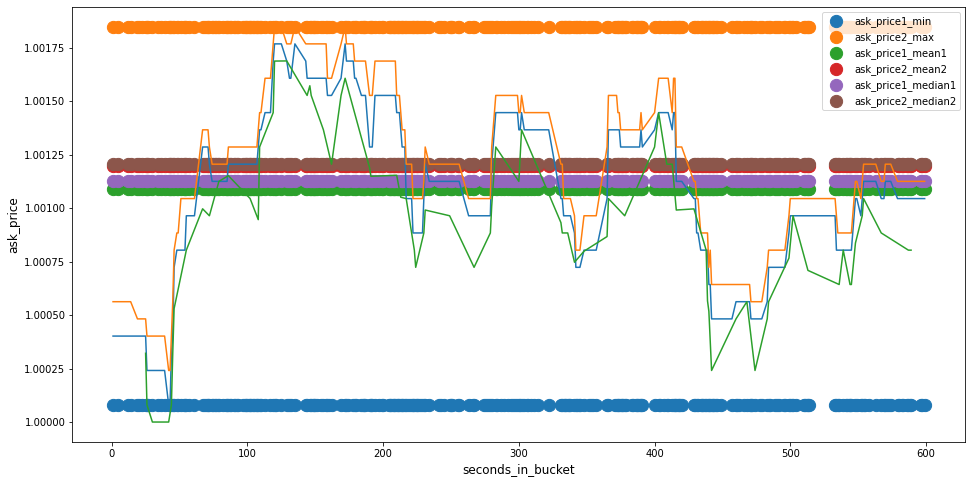

In [49]:
plt.figure(figsize=(16, 8))

plt.plot(book_28_11['seconds_in_bucket'], book_28_11['ask_price1'])
plt.plot(book_28_11['seconds_in_bucket'], book_28_11['ask_price2'])

plt.plot(trade_28_11['seconds_in_bucket'], trade_28_11['price'])

plt.scatter(x=aggs_book_28_11['seconds_in_bucket'], 
            y=aggs_book_28_11['ask_price1_min'],
            s=150,
            label='ask_price1_min'
           )
plt.scatter(x=aggs_book_28_11['seconds_in_bucket'], 
            y=aggs_book_28_11['ask_price2_max'],
            s=150,
            label='ask_price2_max'
           )
plt.scatter(x=aggs_book_28_11['seconds_in_bucket'], 
            y=aggs_book_28_11['ask_price1_mean'],
            s=150,
            label='ask_price1_mean1'
           )
plt.scatter(x=aggs_book_28_11['seconds_in_bucket'], 
            y=aggs_book_28_11['ask_price2_mean'],
            s=150,
            label='ask_price2_mean2'
           )
plt.scatter(x=aggs_book_28_11['seconds_in_bucket'], 
            y=aggs_book_28_11['ask_price1_median'],
            s=150,
            label='ask_price1_median1'
           )
plt.scatter(x=aggs_book_28_11['seconds_in_bucket'], 
            y=aggs_book_28_11['ask_price2_median'],
            s=150,
            label='ask_price2_median2'
           )

plt.xlabel('seconds_in_bucket', fontsize=12)
plt.ylabel('ask_price', fontsize=12)

plt.legend()
plt.show()

In [50]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=book_28_11["seconds_in_bucket"], 
        y=book_28_11["bid_size1"], 
        mode='lines', 
        name='bid_size1'
    )
)
fig.add_trace(
    go.Scatter(
        x=book_28_11["seconds_in_bucket"], 
        y=book_28_11["bid_size2"], 
        mode='lines', 
        name='bid_size2'
    )
)

fig.show()

In [51]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=book_28_11["seconds_in_bucket"], 
        y=book_28_11["ask_size1"], 
        mode='lines', 
        name='ask_size1'
    )
)
fig.add_trace(
    go.Scatter(
        x=book_28_11["seconds_in_bucket"], 
        y=book_28_11["ask_size2"], 
        mode='lines', 
        name='ask_size2'
    )
)

fig.show()

In [52]:
temp_aggs = book_28_11.groupby(['time_id']).agg(
    bid_size1_min = ('bid_size1', 'min'),
    bid_size1_max = ('bid_size1', 'max'),
    bid_size2_min = ('bid_size2', 'min'),
    bid_size2_max = ('bid_size2', 'max'),
    bid_size1_mean = ('bid_size1', 'mean'),
    bid_size2_mean = ('bid_size2', 'mean'),
    bid_size1_median = ('bid_size1', 'median'),
    bid_size2_median = ('bid_size2', 'median'),
    
    ask_size1_min = ('ask_size1', 'min'),
    ask_size1_max = ('ask_size1', 'max'),
    ask_size2_min = ('ask_size2', 'min'),
    ask_size2_max = ('ask_size2', 'max'),
    ask_size1_mean = ('ask_size1', 'mean'),
    ask_size2_mean = ('ask_size2', 'mean'),
    ask_size1_median = ('ask_size1', 'median'),
    ask_size2_median = ('ask_size2', 'median'),              
)

In [53]:
second_aggs_book_28_11 = pd.merge(aggs_book_28_11, temp_aggs, on=['time_id'], how='left')
second_aggs_book_28_11

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,...,bid_size1_median,bid_size2_median,ask_size1_min,ask_size1_max,ask_size2_min,ask_size2_max,ask_size1_mean,ask_size2_mean,ask_size1_median,ask_size2_median
0,11,1,0.999839,1.000402,0.999759,1.000563,101,4,300,304,...,188,144,1,2120,1,905,224.043333,242.32,104,200
1,11,5,0.999839,1.000402,0.999679,1.000563,101,4,100,404,...,188,144,1,2120,1,905,224.043333,242.32,104,200
2,11,12,0.999839,1.000402,0.999679,1.000563,101,4,200,504,...,188,144,1,2120,1,905,224.043333,242.32,104,200
3,11,14,0.999839,1.000402,0.999679,1.000563,101,20,100,504,...,188,144,1,2120,1,905,224.043333,242.32,104,200
4,11,19,0.999839,1.000402,0.999598,1.000482,101,20,100,125,...,188,144,1,2120,1,905,224.043333,242.32,104,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,11,588,1.000804,1.001045,1.000643,1.001125,90,101,201,201,...,188,144,1,2120,1,905,224.043333,242.32,104,200
296,11,589,1.000643,1.001045,1.000482,1.001125,201,101,5,301,...,188,144,1,2120,1,905,224.043333,242.32,104,200
297,11,596,1.000643,1.001045,1.000563,1.001125,201,1,100,201,...,188,144,1,2120,1,905,224.043333,242.32,104,200
298,11,597,1.000643,1.001045,1.000563,1.001125,201,42,100,201,...,188,144,1,2120,1,905,224.043333,242.32,104,200


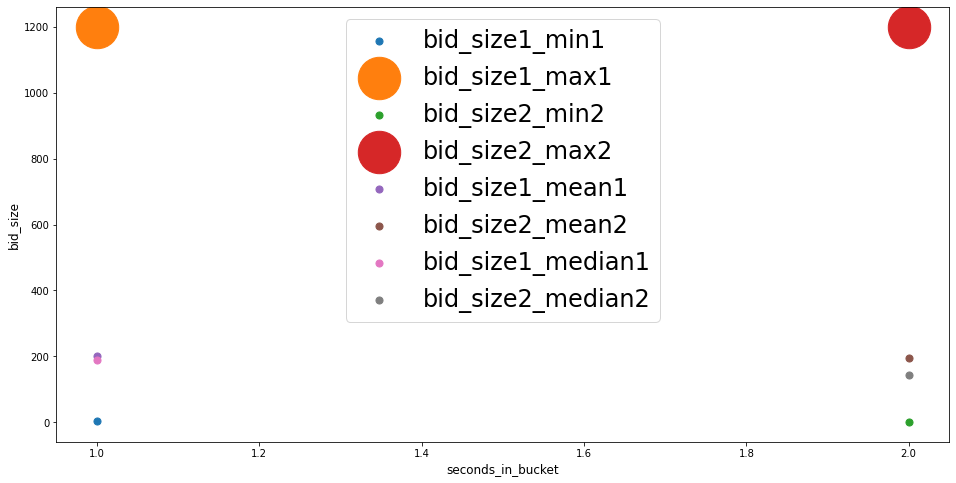

In [54]:
plt.figure(figsize=(16, 8))

plt.scatter(x=1, 
            y=second_aggs_book_28_11['bid_size1_min'].min(),
            s=50,
            label='bid_size1_min1'
           )
plt.scatter(x=1, 
            y=second_aggs_book_28_11['bid_size1_max'].min(),
            s=second_aggs_book_28_11['bid_size1_max'].min() * 1.5,
            label='bid_size1_max1'
           )
plt.scatter(x=2, 
            y=second_aggs_book_28_11['bid_size2_min'].min(),
            s=50,
            label='bid_size2_min2'
           )
plt.scatter(x=2, 
            y=second_aggs_book_28_11['bid_size2_max'].min(),
            s=second_aggs_book_28_11['bid_size2_max'].min() * 1.5,
            label='bid_size2_max2'
           )
plt.scatter(x=1, 
            y=second_aggs_book_28_11['bid_size1_mean'].min(),
            s=50,
            label='bid_size1_mean1'
           )
plt.scatter(x=2, 
            y=second_aggs_book_28_11['bid_size2_mean'].min(),
            s=50,
            label='bid_size2_mean2'
           )
plt.scatter(x=1, 
            y=second_aggs_book_28_11['bid_size1_median'].min(),
            s=50,
            label='bid_size1_median1'
           )
plt.scatter(x=2, 
            y=second_aggs_book_28_11['bid_size2_median'].min(),
            s=50,
            label='bid_size2_median2'
           )


plt.xlabel('seconds_in_bucket', fontsize=12)
plt.ylabel('bid_size', fontsize=12)

plt.legend(loc = "upper center", prop={'size': 24})
plt.show()

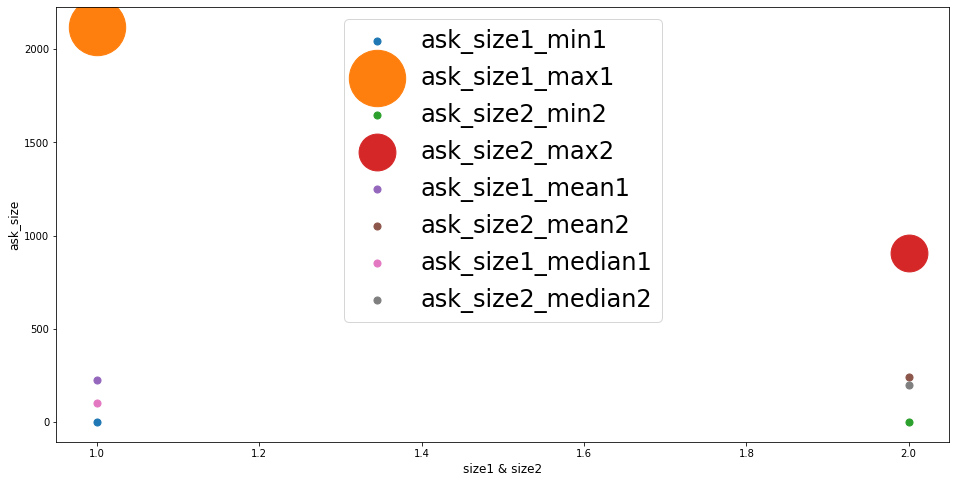

In [55]:
plt.figure(figsize=(16, 8))

plt.scatter(x=1, 
            y=second_aggs_book_28_11['ask_size1_min'].min(),
            s=50,
            label='ask_size1_min1'
           )
plt.scatter(x=1, 
            y=second_aggs_book_28_11['ask_size1_max'].min(),
            s=second_aggs_book_28_11['ask_size1_max'].min() * 1.5,
            label='ask_size1_max1'
           )
plt.scatter(x=2, 
            y=second_aggs_book_28_11['ask_size2_min'].min(),
            s=50,
            label='ask_size2_min2'
           )
plt.scatter(x=2, 
            y=second_aggs_book_28_11['ask_size2_max'].min(),
            s=second_aggs_book_28_11['ask_size2_max'].min() * 1.5,
            label='ask_size2_max2'
           )
plt.scatter(x=1, 
            y=second_aggs_book_28_11['ask_size1_mean'].min(),
            s=50,
            label='ask_size1_mean1'
           )
plt.scatter(x=2, 
            y=second_aggs_book_28_11['ask_size2_mean'].min(),
            s=50,
            label='ask_size2_mean2'
           )
plt.scatter(x=1, 
            y=second_aggs_book_28_11['ask_size1_median'].min(),
            s=50,
            label='ask_size1_median1'
           )
plt.scatter(x=2, 
            y=second_aggs_book_28_11['ask_size2_median'].min(),
            s=50,
            label='ask_size2_median2'
           )


plt.xlabel('size1 & size2', fontsize=12)
plt.ylabel('ask_size', fontsize=12)

plt.legend(loc = "upper center", prop={'size': 24})
plt.show()

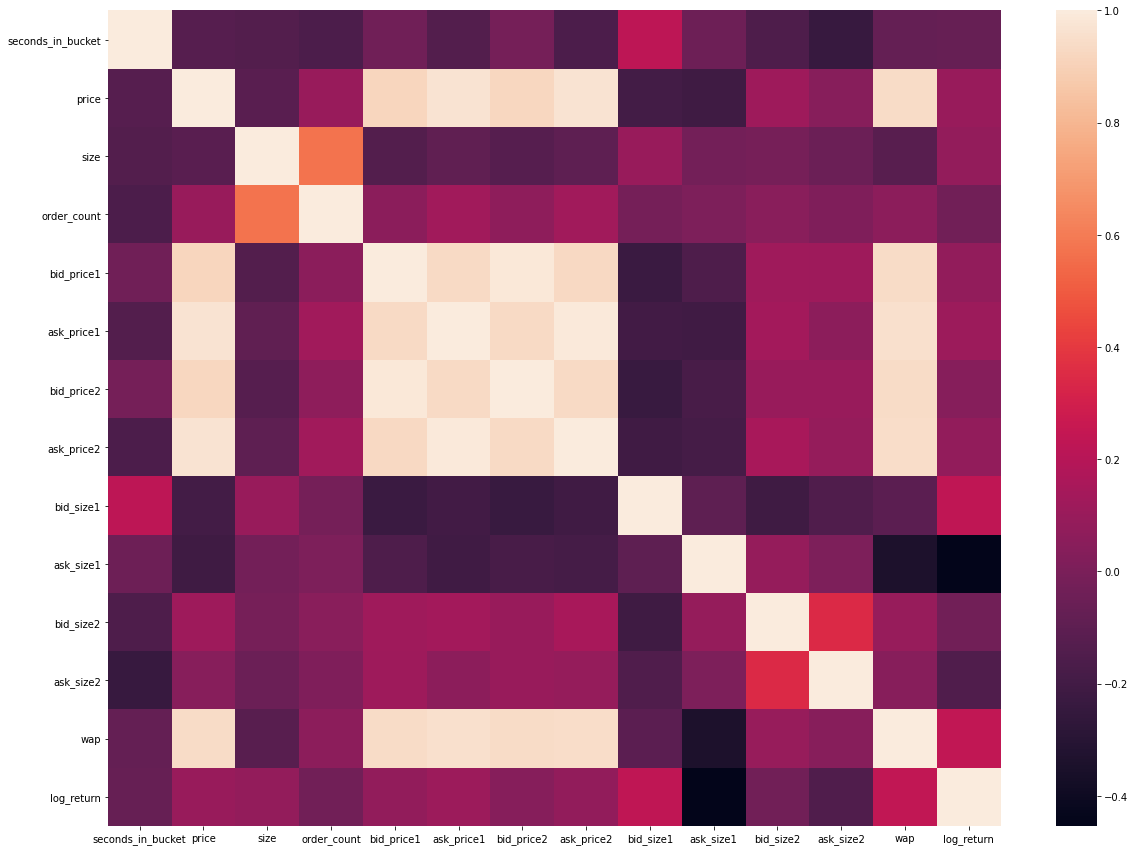

In [56]:
plt.figure(figsize = (20, 15))
whole_28_11 = trade_28_11.merge(book_28_11, on = ["seconds_in_bucket", "time_id", "stock_id"], how = "outer").dropna().drop(["stock_id", "time_id"], 1)
corrmat = whole_28_11.corr()
sns.heatmap(corrmat)
plt.show()